# Reinforcement Learning with Function Approximation

In [ ]:
!pip install torch==1.2.0 torchvision pyvirtualdisplay matplotlib seaborn pandas numpy pathlib gym
!sudo apt-get install xvfb
!git clone https://github.com/rlgammazero/mvarl_hands_on.git > /dev/null 2>&1
!cd mvarl_hands_on && git pull origin master > /dev/null 2>&1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim

import numpy as np

import gym
from gym.wrappers import Monitor
from pprint import pprint
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output

from pathlib import Path
import base64

In [2]:
# The following code is will be used to visualize the environments.
"""
def show_video(directory):
    html = []
    for mp4 in Path(directory).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))
"""

def show_video(directory):
    """Using IPython.display.Video"""
    all_vids = list(Path(directory).glob("*.mp4"))
    for mp4 in all_vids:
        vid = ipythondisplay.Video(mp4)
        ipythondisplay.display(vid)
    
display = Display(visible=0, size=(900, 400))
display.start();

def make_seed(seed):
    np.random.seed(seed=seed)
    torch.manual_seed(seed=seed)

PyTorch is a Python package that provides two high-level features:
- Tensor computation (like NumPy) with strong GPU acceleration
- Deep neural networks built on a tape-based autograd system

At a granular level, PyTorch is a library that consists of the following components:

| Component | Description |
| ---- | --- |
| [**torch**](https://pytorch.org/docs/stable/torch.html) | a Tensor library like NumPy, with strong GPU support |
| [**torch.autograd**](https://pytorch.org/docs/stable/autograd.html) | a tape-based automatic differentiation library that supports all differentiable Tensor operations in torch |
| [**torch.jit**](https://pytorch.org/docs/stable/jit.html) | a compilation stack (TorchScript) to create serializable and optimizable models from PyTorch code  |
| [**torch.nn**](https://pytorch.org/docs/stable/nn.html) | a neural networks library deeply integrated with autograd designed for maximum flexibility |
| [**torch.multiprocessing**](https://pytorch.org/docs/stable/multiprocessing.html) | Python multiprocessing, but with magical memory sharing of torch Tensors across processes. Useful for data loading and Hogwild training |
| [**torch.utils**](https://pytorch.org/docs/stable/data.html) | DataLoader and other utility functions for convenience |


**Tutorials on PyTorch:** https://pytorch.org/tutorials/


## OpenAI gym
We will consider environments provided by OpenAI gym
This library provides a large number of environments to test RL algorithm.

We will focus on the **CartPole-v1** environment in this lab but we encourage you to also test your code on:
* **Acrobot-v1**
* **MountainCar-v0**

| Env Info          	| CartPole-v1 	| Acrobot-v1                	| MountainCar-v0 	|
|-------------------	|-------------	|---------------------------	|----------------	|
| **Observation Space** 	| Box(4)      	| Box(6)                    	| Box(2)         	|
| **Action Space**      	| Discrete(2) 	| Discrete(3)               	| Discrete(3)    	|
| **Rewards**           	| 1 per step  	| -1 if not terminal else 0 	| -1 per step    	|

A gym environment is loaded with the command `env = gym.make(env_id)`. Once the environment is created, you need to reset it with `observation = env.reset()` and then you can interact with it using the method step: `observation, reward, done, info = env.step(action)`.

In [3]:
# We load CartPole-v1
env = gym.make('CartPole-v1')
# We wrap it in order to save our experiment on a file.
env = Monitor(env, "./gym-results", force=True)

In [4]:
done = False
obs = env.reset()
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
env.close()
show_video("./gym-results")

## REINFORCE

**Q1: Implement the REINFORCE algorithm**

The code is splitted in two parts:
* The Model class defines the architecture of our neural network which takes as input the current state and returns the policy,
* The Agent class is responsible for the training and evaluation procedure. You will need to code the method `optimize_model`.

In [5]:
class Model(nn.Module):
    def __init__(self, dim_observation, n_actions):
        super(Model, self).__init__()
        
        self.n_actions = n_actions
        self.dim_observation = dim_observation
        
        self.net = nn.Sequential(
            nn.Linear(in_features=self.dim_observation, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=self.n_actions),
            nn.Softmax(dim=0)
        )
        
    def forward(self, state):
        return self.net(state)
    
    def select_action(self, state):
        action = torch.multinomial(self.forward(state), 1)
        return action

Create the model based on the properties of the MDP you want to solve

In [6]:
env_id = 'CartPole-v1'
env = gym.make(env_id)
model = Model(env.observation_space.shape[0], env.action_space.n)
print(f'The model we created correspond to:\n{model}')

The model we created correspond to:
Model(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=2, bias=True)
    (5): Softmax(dim=0)
  )
)


We provide a base agent that you will need to extend in the next cell with your implementation of `optimize_model`.

In [7]:
import pandas as pd
import itertools
import seaborn as sns

class BaseAgent:
    
    def __init__(self, config):
        self.config = config
        self.env = gym.make(config['env_id'])
        make_seed(config['seed'])
        self.env.seed(config['seed'])
        self.model = Model(self.env.observation_space.shape[0],
                           self.env.action_space.n)
        self.gamma = config['gamma']
        
        # the optimizer used by PyTorch (Stochastic Gradient, Adagrad, Adam, etc.)
        self.optimizer = torch.optim.Adam(self.model.net.parameters(), lr=config['learning_rate'])
        self.monitor_env = Monitor(self.env, "./gym-results", force=True, 
                                   video_callable=lambda episode: True)
    
        self.current_ep = 0
        self.rewards = []
    
    # Method to implement
    def _compute_returns(self, rewards):
        """Returns the cumulative discounted rewards at each time step

        Parameters
        ----------
        rewards : array
            The array of rewards of one episode

        Returns
        -------
        array
            The cumulative discounted rewards at each time step
            
        Example
        -------
        for rewards=[1, 2, 3] this method outputs [1 + 2 * gamma + 3 * gamma**2, 2 + 3 * gamma, 3] 
        """
        
        raise NotImplementedError
    
    # Method to implement
    def optimize_model(self, n_trajectories):
        """Perform a gradient update using n_trajectories

        Parameters
        ----------
        n_trajectories : int
            The number of trajectories used to approximate the expectation card(D) in the formula above
        
        Returns
        -------
        array
            The cumulative discounted rewards of each trajectory
        """
        
        raise NotImplementedError
    
    def train(self, n_trajectories, n_update):
        """Training method

        Parameters
        ----------
        n_trajectories : int
            The number of trajectories used to approximate the expected gradient
        n_update : int
            The number of gradient updates
            
        """
        
        final_update = self.current_ep + n_update
        rewards = self.rewards  # restart the reward record
        for episode in range(self.current_ep, final_update):
            rewards.append(self.optimize_model(n_trajectories))
            print(f'Episode {episode + 1}/{final_update}: rewards ' 
                  +f'{round(rewards[-1].mean(), 2)} +/- {round(rewards[-1].std(), 2)}')
            self.current_ep += 1
        
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards[i]) for i in range(len(rewards))))), columns=['Epoch', 'Reward'])
        sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');
        
    def evaluate(self, render=False):
        """Evaluate the agent on a single trajectory            
        """
        
        ## Wrap in torch.no_grad to stop the tape recorder
        ## and stop the RAM from blowing up
        with torch.no_grad():
            observation = self.monitor_env.reset()
            observation = torch.from_numpy(observation).float()
            reward_episode = 0
            done = False
            while not done:
                action = self.model.select_action(observation)
                observation, reward, done, info = self.monitor_env.step(int(action))
                observation = torch.from_numpy(observation).float()
                reward_episode = self.gamma * reward_episode + reward
        self.monitor_env.close()
        if render:
            show_video("./gym-results")
        print(f'Reward: {reward_episode}')
        

Finally you can implement your agent

**Recall** The REINFORCE algorithm uses an unbiased estimate of the gradient of
$$
    J(\pi_\theta) = \mathbb E_{\tau\sim \mathbb P_\theta}\left[ R(\tau) \right]
    = \mathbb E_\tau \left[
        \sum_{t=0}^T \gamma^t r_t
    \right]
$$
which has exact gradient
$$
    \nabla_\theta J(\pi_\theta) = \mathbb E_{\tau\sim\mathbb P_\theta}
    \left[ R(\tau)\nabla_\theta \log \pi_\theta \right] =
    \mathbb E_\tau\left[
    \left(\sum_{t=0}^T \gamma^t r_t\right)
    \left(\sum_{t=0}^T \nabla_\theta\log \pi_\theta(s_t, a_t) \right)
    \right]
$$

We introduce the pseudo-likelihood
$$
    L(\theta) = \frac{1}{M}\sum_{i=1}^M
    \left(\sum_{t=0}^T \gamma^t r^i_t\right)
    \left(\sum_{t=0}^T \log \pi_\theta(s^i_t, a^i_t) \right) \geq 0
$$
so that
$$
    \nabla_\theta L(\theta)
$$
is an unbiased estimate of the policy gradient $\nabla_\theta J(\theta)$.

In [8]:
class REINFORCE(BaseAgent):
    
    def _compute_returns(self, rewards):
        num_rew = len(rewards)
        exponents = np.arange(num_rew)
        gammas = np.power(self.gamma, exponents)
        
        return rewards.dot(gammas)
    
        
    def optimize_model(self, n_trajectories):

        env = self.env
        reward_trajectories = np.empty(n_trajectories)
        loss = 0.
        
        for i in range(n_trajectories):
            traj_rewards = []  # rewards of the trajectory
            traj_proba = 0.  # sum of log-probabilities of trajectory
            
            # Build trajectory
            done = False
            obs = env.reset()
            obs = torch.from_numpy(obs).float()  # state s0
            while not done:
                action = self.model.select_action(obs)  # can be cast to int for action idx
                # Get proba
                prob = self.model(obs)[int(action)]
                traj_proba += torch.log(prob)
                
                obs, reward, done, info = env.step(int(action))
                
                obs = torch.from_numpy(obs).float()
                # Store the new reward
                traj_rewards.append(reward)
                
                
            traj_rewards = np.array(traj_rewards)  # NumPy array
            
            # Get total reward
            total_reward = self._compute_returns(traj_rewards)  # NumPy array
            reward_trajectories[i] = total_reward
            
            loss = loss + total_reward * traj_proba / n_trajectories  # accumulate the negative criterion
        
        env.close()  # important
        
        loss = -loss
        
        # The following lines take care of the gradient descent step for the variable loss
        # that you need to compute.
        print("Loss:", loss.data.numpy())
        
        # Discard previous gradients
        self.optimizer.zero_grad()
        # Compute the gradient 
        loss.backward()
        # Do the gradient descent step
        self.optimizer.step()
        return reward_trajectories
    

In [9]:
env_id = 'CartPole-v1'
learning_rate = 0.015
gamma = 1.0  # every second counts the same
seed = 1235

config = {
    'env_id': env_id,
    'learning_rate': learning_rate,
    'seed': seed,
    'gamma': gamma
}

print("Current config is:")
pprint(config)


Current config is:
{'env_id': 'CartPole-v1', 'gamma': 1.0, 'learning_rate': 0.015, 'seed': 1235}


Loss: 315.27423
Episode 1/64: rewards 19.12 +/- 9.49
Loss: 521.7329
Episode 2/64: rewards 24.73 +/- 11.84
Loss: 386.60022
Episode 3/64: rewards 21.64 +/- 9.51
Loss: 510.77228
Episode 4/64: rewards 23.37 +/- 13.92
Loss: 580.80133
Episode 5/64: rewards 24.76 +/- 15.26
Loss: 520.22894
Episode 6/64: rewards 24.04 +/- 13.38
Loss: 558.75836
Episode 7/64: rewards 25.52 +/- 12.8
Loss: 622.01666
Episode 8/64: rewards 26.6 +/- 14.45
Loss: 740.3721
Episode 9/64: rewards 28.71 +/- 16.4
Loss: 964.107
Episode 10/64: rewards 32.19 +/- 19.85
Loss: 1108.002
Episode 11/64: rewards 32.95 +/- 23.93
Loss: 1111.6567
Episode 12/64: rewards 34.43 +/- 21.95
Loss: 908.49414
Episode 13/64: rewards 32.32 +/- 17.95
Loss: 1045.6062
Episode 14/64: rewards 35.4 +/- 18.0
Loss: 1198.4823
Episode 15/64: rewards 37.68 +/- 20.54
Loss: 1046.5044
Episode 16/64: rewards 35.75 +/- 18.17
Loss: 1075.5834
Episode 17/64: rewards 36.16 +/- 18.48
Loss: 1223.8119
Episode 18/64: rewards 38.48 +/- 20.45
Loss: 1658.1143
Episode 19/64: 

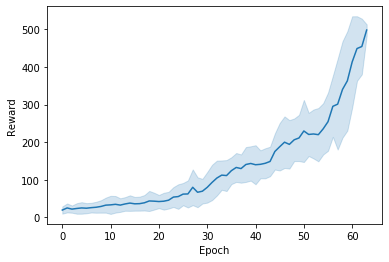

In [10]:
agent = REINFORCE(config)

agent.train(n_trajectories=75, n_update=64)

Now, we evaluate the agent over multiple episodes:

In [11]:
agent.evaluate(render=True)

Reward: 500.0


In [12]:
import os
import datetime

# Save the model
datetag = datetime.datetime.now().strftime("%d%m%Y-%H%M%S")

PATH = f"saved_models/reinforce_{datetag}.pth"
PATH

torch.save(model.state_dict(), PATH)

## Policy Evaluation as Supervised Learning

**Q2: Implement batched gradient algorithm**

Define network for value function (ValueNetwork) and policy (ActorNetwork)


The `ValueNetwork` is an estimate $v_\nu$ (parameterized by $\nu \in \mathcal V$) of the value function $V^{\pi_\theta}$ of the current policy model $\pi_\theta$ (parameterized by $\theta\in\Theta$).

In [10]:
class ValueNetwork(nn.Module):
    r"""
    Approximation of the value function V under the current policy.
    
    This is the 'critic'.
    """

    def __init__(self, input_size, hidden_size, output_size):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
    
    def predict(self, x):
        return self(x).detach().numpy()[0]

class ActorNetwork(nn.Module):
    r"""
    Policy model network for the agent.
    """
    def __init__(self, input_size, hidden_size, action_size):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.softmax(self.fc3(out), dim=-1)
        return out
    
    def select_action(self, x):
        return torch.multinomial(self(x), 1).detach().numpy()

The following `EvalAgent` defines an **evaluation agent**: using the prescribed policy $\pi$, it runs trajectories to fit an estimate of the value function $V^\pi$ modelled as a neural network $\hat{v}_\nu(s)$.

In [11]:
class EvalAgent:
    """
    This agent runs the prescribed policy (but does not learn it)
    """
    def __init__(self, config, policy):
        self.config = config
        self.env = gym.make(config['env_id'])
        make_seed(config['seed'])
        self.env.seed(config['seed'])
        self.monitor_env = Monitor(self.env, "./gym-results",
                                   force=True, video_callable=lambda episode: True)
        self.gamma = config['gamma']
        self.policy: ActorNetwork = policy

        self.value_hidden = 16
        # Our network
        self.value_network: ValueNetwork = ValueNetwork(
            self.env.observation_space.shape[0], self.value_hidden, 1)

        # optimizer -- singular: only for the value network
        self.value_network_optimizer = optim.RMSprop(
            self.value_network.parameters(),
            lr=config['value_network']['learning_rate'])
    
    def _compute_returns(self, rewards, dones, next_value):
        """Returns the cumulative discounted rewards at each time step.
        We are going to fit the value_network on this.
        
        Parameters
        ----------
        rewards : array
            An array of shape (batch_size,) containing the rewards given by the env
        dones : array
            An array of shape (batch_size,) containing the done bool indicator given by the env
        next_value : float
            The (estimated) value of the next state given by the value network

        Returns
        -------
        returns : array
            The estimate of the advantage -- or rather the returns
        """
        returns_ = np.empty_like(rewards)
        R = next_value
        for i in range(1, len(rewards)+1):
            retro_prop = 1-dones[-i]  # whether to use the following value
            R = rewards[-i] + self.gamma * retro_prop * R
            returns_[-i] = R
        
        
        
        return returns_
    
    
    def optimize_model(self, observations, returns): #actions, returns, advantages): what ?
        """Perform a gradient update using provided transitions

        Parameters
        ----------
        observations : array
            The observations
        returns : array
            The returns from each state

        Returns
        -------
        loss_value: int  <--- what ??
            The loss value
        """
        # Cast our array buffers into tensors
        returns = torch.from_numpy(returns[:, None]).float()  # shape (batch_size,1)
        observations = torch.from_numpy(observations).float()
        
        
        ## STEP ONE: FIT THE VALUE NETWORK TO THE RETURNS
        network_values = self.value_network(observations)  # shape (batch_size,)
        mse_values = F.mse_loss(network_values, returns)
        #print("MSE values:", mse_values.item())
        
        # rmk: graph of mse_values only depends on weights of value_network
        mse_values.backward()  # backprop step
        self.value_network_optimizer.step()  # optimizer step
        self.value_network_optimizer.zero_grad()  # zero the gradients
        
        return
    
    def training_batch(self, epochs, batch_size):
        """Train the model over multiple epochs, by batches.

        Parameters
        ----------
        epochs : int
            Number of epochs
        batch_size : int
            The size of a batch
        """
        episode_count = 0
        actions = np.empty((batch_size,), dtype=np.int)
        dones   = np.empty((batch_size,), dtype=np.bool)
        rewards = np.empty((batch_size,), dtype=np.float)
        
        ## shape (batch_size, *obs_dims) -- buffer for observations
        observations = np.empty(
            (batch_size,) + self.env.observation_space.shape,
            dtype=np.float)
        
        env = self.env
        
        obs = env.reset()
        mse_test = []

        ## EPISODE = TRAJECTORY
        
        for epoch in range(epochs):
            # Collect the variables computed at the previous step
            for i in range(batch_size):
                observations[i] = obs  # just observed s_t
                obs_ = torch.from_numpy(obs).float()  # tensor
                action = self.policy.select_action(obs_)  # act on just observed, action a_t
                actions[i] = int(action)
                
                obs, reward, done, _ = self.env.step(int(action))  # step with env
                
                dones[i] = done
                rewards[i] = reward
                
                # check if the observation we just got was terminal
                if dones[i]:
                    obs = self.env.reset()

            # If our episode didn't end on the last step we need to compute the value for the last state
            if dones[-1]:
                next_value = 0  # no value function adjustment
            else:
                obs_ = torch.from_numpy(obs).float()
                next_value = self.value_network(obs_)
            
            # Update episode_count
            episode_count += sum(dones)

            # Compute returns over the batch
            returns = self._compute_returns(rewards, dones, next_value)
            
            # Learning step !
            self.optimize_model(observations, returns)
            
            obs = env.reset()
            
            # Run a test of the value fit, every 50 epochs
            if (epoch > 0 and epoch % 25 == 0) or epoch == epochs - 1:
                L = []
                for _ in range(10):
                    obs_states, y_mc = self.evaluate()
                    obs_states_tensor = torch.from_numpy(obs_states).float()  # no-copy tensor
                    y_hat = self.value_network(obs_states_tensor).detach().numpy()
                    err = y_mc - y_hat
                    mse = np.mean(err ** 2)
                    L.append(mse.item())
                mse_test.append(L)
                print(f'Epoch {epoch}/{epochs}: Value MSE: {np.mean(mse)}')

        env.close()
        
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], mse_test[i]) for i in range(len(mse_test))))), columns=['Epoch', 'MSE'])
        sns.lineplot(x="Epoch", y="MSE", data=r, ci='sd');

        print(f'The training was done over a total of {episode_count} episodes')

    def evaluate(self, render=False):
        """Returns the observations and the estimated V-function (using first visit Monte-Carlo)

        Returns
        -------
        states : array
            Observations
        returns : array
            The estimate value function of each state
        """
        env = self.monitor_env if render else self.env
        observation = env.reset()
        states = [observation.copy()]
        rewards= []
        observation = torch.from_numpy(observation).float()
        done = False
        steps = 0

        with torch.no_grad():  # avoid wrecking the RAM
            while not done:
                action = self.policy.select_action(observation)


                observation, reward, done, info = env.step(int(action))
                for i in range(steps):
                    rewards[i] = rewards[i] + np.power(self.gamma, steps-i)*reward
                rewards.append(reward)
                if not done:
                    states.append(observation.copy())
                observation = torch.from_numpy(observation).float()
                steps += 1

        env.close()
        if render:
            show_video("./gym-results")
            print(f'Reward: {reward_episode}')
        states = np.array(states).reshape(-1, self.env.observation_space.shape[0])
        returns = np.array(rewards).reshape(-1,1)
        return states, returns

Define configuration

In [12]:
env_id = 'CartPole-v1'
value_learning_rate = 0.0018
gamma = 0.99
seed = 1

config_td = {
    'env_id': env_id,
    'gamma': gamma,
    'seed': seed,
    'value_network': {'learning_rate': value_learning_rate, 'reference': './CartPole_value.pt'}
}

print("Current config_td is:")
pprint(config_td)


Current config_td is:
{'env_id': 'CartPole-v1',
 'gamma': 0.99,
 'seed': 1,
 'value_network': {'learning_rate': 0.0018, 'reference': './CartPole_value.pt'}}


We create the policy network: for now we will use a prescribed, pre-trained policy.

In [13]:
env = gym.make(config_td['env_id'])

## Define the policy network
policy = ActorNetwork(env.observation_space.shape[0], 16, env.action_space.n)  # policy model network
policy.load_state_dict(torch.load('./mvarl_hands_on/data/CartPole_actor.pt'))  # load pre-trained weights
state = torch.from_numpy(env.reset()).float()  # initial state
print("pi(state) = ", policy.select_action(state))
# del env

pi(state) =  [1]


Run agent

In [14]:
agent = EvalAgent(config=config_td, policy=policy)

In [15]:
## For sanity
def _test_compute_returns():
    n = 20
    rewards = np.ones(n)
    dones = np.zeros(n, dtype=np.bool)
    dones[11] = True
    print("rewards:", rewards)
    print("dones:  ", dones)
    
    next_value = 0
    res = agent._compute_returns(rewards, dones, next_value)
    return res

_test_compute_returns()

rewards: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
dones:   [False False False False False False False False False False False  True
 False False False False False False False False]


array([11.36151283, 10.46617457,  9.5617925 ,  8.64827525,  7.72553056,
        6.79346521,  5.85198506,  4.90099501,  3.940399  ,  2.9701    ,
        1.99      ,  1.        ,  7.72553056,  6.79346521,  5.85198506,
        4.90099501,  3.940399  ,  2.9701    ,  1.99      ,  1.        ])

Epoch 25/800: Value MSE: 6699.2783622987345
Epoch 50/800: Value MSE: 5991.503593194566
Epoch 75/800: Value MSE: 5000.36452257365
Epoch 100/800: Value MSE: 3896.6062193060234
Epoch 125/800: Value MSE: 2774.2764289402803
Epoch 150/800: Value MSE: 1984.9105483982623
Epoch 175/800: Value MSE: 1343.6016007314533
Epoch 200/800: Value MSE: 867.686032616007
Epoch 225/800: Value MSE: 774.4276227922157
Epoch 250/800: Value MSE: 625.192739645155
Epoch 275/800: Value MSE: 611.1459028769558
Epoch 300/800: Value MSE: 678.7645192390694
Epoch 325/800: Value MSE: 632.5247390937847
Epoch 350/800: Value MSE: 685.1034250006016
Epoch 375/800: Value MSE: 672.3947369860234
Epoch 400/800: Value MSE: 581.2606737359262
Epoch 425/800: Value MSE: 615.2470994797874
Epoch 450/800: Value MSE: 670.8317830639302
Epoch 475/800: Value MSE: 611.3586502816598
Epoch 500/800: Value MSE: 1065.0124682544758


/home/manifold/miniconda3/envs/torch/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Epoch 525/800: Value MSE: 610.211428698839
Epoch 550/800: Value MSE: 614.0521261402993
Epoch 575/800: Value MSE: 592.7664170474463
Epoch 600/800: Value MSE: 586.63135467209
Epoch 625/800: Value MSE: 619.1606849363673
Epoch 650/800: Value MSE: 609.0073950952403
Epoch 675/800: Value MSE: 590.8101960486318
Epoch 700/800: Value MSE: 614.1035989062791
Epoch 725/800: Value MSE: 596.674730274731
Epoch 750/800: Value MSE: 601.3044319361793
Epoch 775/800: Value MSE: 949.6450564352031
Epoch 799/800: Value MSE: 613.743812340003
The training was done over a total of 834 episodes


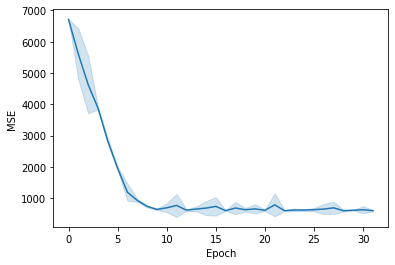

In [763]:
EPOCHS = 800
batch_size = 512
agent.training_batch(epochs=EPOCHS, batch_size=batch_size)

## Advantage Actor Critic (A2C)
**Q3: Implement the A2C method**

As usual we provide a structure you can use as starting point.



**Note:** try to reuse previous parts of previous code.

In [31]:
class A2CAgent:

    def __init__(self, config):
        self.config = config
        self.env = gym.make(config['env_id'])
        make_seed(config['seed'])
        self.env.seed(config['seed'])
        self.monitor_env = Monitor(self.env, "./gym-results", force=True, video_callable=lambda episode: True)
        self.gamma = config['gamma']
        self.entropy = config['entropy']
        
        # Our two networks
        self.value_network = ValueNetwork(self.env.observation_space.shape[0], 16, 1)
        self.actor_network = ActorNetwork(self.env.observation_space.shape[0], 16, self.env.action_space.n)
        
        # Their optimizers
        self.value_network_optimizer: optim.Optimizer = optim.RMSprop(
            self.value_network.parameters(), lr=config['value_network']['learning_rate'])
        self.actor_network_optimizer: optim.Optimizer = optim.RMSprop(
            self.actor_network.parameters(), lr=config['actor_network']['learning_rate'])
        
    # Hint: use it during training_batch
    def _returns_advantages(self, rewards, dones, values, next_value):
        """Returns the cumulative discounted rewards at each time step

        Parameters
        ----------
        rewards : array
            An array of shape (batch_size,) containing the rewards given by the env
        dones : array
            An array of shape (batch_size,) containing the done bool indicator given by the env
        values : array
            An array of shape (batch_size,) containing the values given by the value network
        next_value : float
            The value of the next state given by the value network
        
        Returns
        -------
        returns : array
            The cumulative discounted rewards
        advantages : array
            The advantages
        """
        returns_ = np.empty_like(rewards)
        
        R = next_value
        for i in range(1, len(rewards)+1):
            retro_prop = 1-dones[-i]  # whether to use the following value
            R = rewards[-i] + self.gamma * retro_prop * R
            returns_[-i] = R
        
        
        #advantages = rewards
        #advantages[:-1] += (1-dones[:-1]) * self.gamma * values[1:] - values[:-1]
        #advantages[-1] += (1-dones[-1]) * self.gamma * next_value - values[-1]
        advantages = returns_ - values
        return returns_, advantages

    def training_batch(self, epochs, batch_size):
        """Perform a training by batch

        Parameters
        ----------
        epochs : int
            Number of epochs
        batch_size : int
            The size of a batch
        """
        env = self.env
        episode_count = 0
        actions = np.empty((batch_size,), dtype=np.int)
        dones = np.empty((batch_size,), dtype=np.bool)
        rewards, values = np.empty((2, batch_size), dtype=np.float)
        observations = np.empty((batch_size,) + self.env.observation_space.shape, dtype=np.float)
        obs = self.env.reset()
        rewards_test = []

        for epoch in range(epochs):
            # Lets collect one batch
            for i in range(batch_size):
                observations[i] = obs  # just observed s_t
                obs_t = torch.from_numpy(obs).float()  # tensor
                action = self.actor_network.select_action(obs_t)  # act on just observed, action a_t
                actions[i] = int(action)
                values[i] = self.value_network(obs_t)  # vhat[t]
                
                ## Run a step
                obs, reward, done, _ = self.env.step(int(action))  # step with env: get (s[t+1], r[t])
                
                # Store status & reward
                dones[i]   = done
                rewards[i] = reward
                
                # check if the observation we just got was terminal
                if dones[i]:
                    obs = env.reset()

            # If our episode didn't end on the last step we need to compute the value for the last state
            if dones[-1]:
                next_value = 0  # no value function adjustment
            else:
                obs_t = torch.from_numpy(observations[-1]).float()
                next_value = self.value_network.predict(obs_t)
            
            # Update episode_count
            episode_count += sum(dones)

            # Compute returns and advantages
            returns, advantages = self._returns_advantages(rewards, dones, values, next_value)

            # Learning step !
            self.optimize_model(observations, actions, returns, dones, advantages)
            
            
            # Test it every 50 epochs
            if epoch == 10 or (epoch > 0 and epoch % 25 == 0) or epoch == epochs - 1:
                rewards_test.append(np.array([self.evaluate() for _ in range(50)]))
                print(f'Epoch {epoch}/{epochs}: Mean rewards: {round(rewards_test[-1].mean(), 2)}, Std: {round(rewards_test[-1].std(), 2)}')

                # Early stopping
                if rewards_test[-1].mean() > 490 and epoch != epochs -1:
                    print('Early stopping !')
                    break
            
            obs = self.env.reset()
        
        env.close()
        
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards_test[i]) for i in range(len(rewards_test))))), columns=['Epoch', 'Reward'])
        sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');
        
        print(f'The training was done over a total of {episode_count} episodes')

    def optimize_model(self, observations, actions, returns, dones, advantages):
        n_trajs = np.sum(dones)
        actions_idx = actions
        actions      = F.one_hot(torch.from_numpy(actions), self.env.action_space.n)
        returns      = torch.from_numpy(returns[:, None]).float()
        advantages   = torch.from_numpy(advantages).float()
        observations = torch.from_numpy(observations).float()  # shape (batch_size,)
        
        # Critic loss
        net_values: torch.Tensor = self.value_network(observations)
        #critic_loss = F.mse_loss(net_values, returns)
        
        critic_loss = -torch.mean(advantages * net_values)  # completely equivalent using pseudo-loss
        critic_loss.backward()
        
        self.value_network_optimizer.step()
        
        # Actor & Entropy loss
        
        prob: torch.Tensor = self.actor_network(observations)  # shape (batch_size,action_space)
        
        if not dones[-1]:
            n_trajs += 1
        
        loss = 0.
        
        for i in range(len(observations)):
            loss += torch.log(prob[i, actions_idx[i]])*advantages[i]
        
        loss = -loss
        entropy_term = self.entropy * torch.sum(prob * torch.log(prob))
        loss += entropy_term
        loss = loss / n_trajs
        
        loss.backward()
        
        self.actor_network_optimizer.step()
        
        self.value_network_optimizer.zero_grad()
        self.actor_network_optimizer.zero_grad()

        
        return loss.detach().numpy()

    def evaluate(self, render=False):
        env = self.monitor_env if render else self.env
        observation = env.reset()
        observation = torch.from_numpy(observation).float()
        reward_episode = 0
        done = False
        with torch.no_grad():
            while not done:
                policy = self.actor_network(observation)
                action = torch.multinomial(policy, 1)  # draw an action
                observation, reward, done, info = env.step(int(action))
                observation = torch.from_numpy(observation).float()
                reward_episode += reward
            
        env.close()
        if render:
            show_video("./gym-results")
            print(f'Reward: {reward_episode}')
        return reward_episode

Create configuration for A2C

In [32]:
env_id = 'CartPole-v1'
value_learning_rate = 0.0010
actor_learning_rate = 0.0010
gamma = 0.99
entropy = 0.0011
seed = 1

config_a2c = {
    'env_id': env_id,
    'gamma': gamma,
    'seed': seed,
    'value_network': {'learning_rate': value_learning_rate},
    'actor_network': {'learning_rate': actor_learning_rate},
    'entropy': entropy
}

print("Current config_a2c is:")
pprint(config_a2c)

Current config_a2c is:
{'actor_network': {'learning_rate': 0.001},
 'entropy': 0.0011,
 'env_id': 'CartPole-v1',
 'gamma': 0.99,
 'seed': 1,
 'value_network': {'learning_rate': 0.001}}


Run the learning agent

Epoch 10/1000: Mean rewards: 27.28, Std: 18.17
Epoch 25/1000: Mean rewards: 30.44, Std: 18.89
Epoch 50/1000: Mean rewards: 45.02, Std: 25.55
Epoch 75/1000: Mean rewards: 55.42, Std: 27.94
Epoch 100/1000: Mean rewards: 77.98, Std: 42.76
Epoch 125/1000: Mean rewards: 127.84, Std: 77.57
Epoch 150/1000: Mean rewards: 188.68, Std: 84.68
Epoch 175/1000: Mean rewards: 223.4, Std: 97.46
Epoch 200/1000: Mean rewards: 199.96, Std: 89.63
Epoch 225/1000: Mean rewards: 239.8, Std: 87.22
Epoch 250/1000: Mean rewards: 264.48, Std: 96.99
Epoch 275/1000: Mean rewards: 258.1, Std: 97.79
Epoch 300/1000: Mean rewards: 344.64, Std: 121.69
Epoch 325/1000: Mean rewards: 336.16, Std: 133.71
Epoch 350/1000: Mean rewards: 326.84, Std: 105.38
Epoch 375/1000: Mean rewards: 346.12, Std: 103.17
Epoch 400/1000: Mean rewards: 377.74, Std: 101.34
Epoch 425/1000: Mean rewards: 368.32, Std: 115.3
Epoch 450/1000: Mean rewards: 408.62, Std: 99.92
Epoch 475/1000: Mean rewards: 396.98, Std: 100.09
Epoch 500/1000: Mean rewar

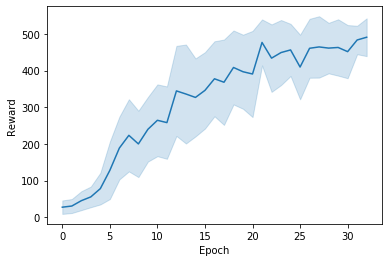

In [33]:
agent = A2CAgent(config_a2c)
EPOCHS = 1000
BATCH_SIZE = 384
rewards = agent.training_batch(EPOCHS, BATCH_SIZE)

Evaluate the agent over multiple episodes

In [840]:
agent.evaluate()

500.0